In [1]:
# !pip install mdtraj ase nglview

In [2]:
# import os
# import torch
# os.environ['TORCH'] = torch.__version__
# print(torch.__version__)

# !pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

In [3]:
import mdtraj as md
from ase import Atoms
import nglview as nv
import networkx as nx

import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm

import torch_geometric.transforms as T
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, SAGPooling, InnerProductDecoder
import torch_geometric.data as data
from torch_geometric.utils.convert import to_networkx
import torch.optim.lr_scheduler as lr_scheduler
from torch.nn import Linear
import sys
import os
import time
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
from torch_geometric.nn import TransformerConv, GATConv, TopKPooling, BatchNorm

import torch.nn.functional as F
from torch_geometric.transforms import pad



Bad key "text.kerning_factor" on line 4 in
/home2/naval.s/anaconda3/envs/GAENN/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [4]:
n_frames,n_atoms,n_mols = (0,0,0)
n_neigh = 15

In [5]:
from typing import Optional, Tuple 

import torch
from torch import Tensor
from torch.nn import Module

from torch_geometric.nn.inits import reset
from torch_geometric.utils import negative_sampling

EPS = 1e-15
MAX_LOGSTD = 10


class InnerProductDecoder(torch.nn.Module):
    r"""The inner product decoder from the `"Variational Graph Auto-Encoders"
    <https://arxiv.org/abs/1611.07308>`_ paper

    .. math::
        \sigma(\mathbf{Z}\mathbf{Z}^{\top})

    where :math:`\mathbf{Z} \in \mathbb{R}^{N \times d}` denotes the latent
    space produced by the encoder."""

    def forward(self, z: Tensor, edge_index: Tensor,
                sigmoid: bool = True) -> Tensor:
        r"""Decodes the latent variables :obj:`z` into edge probabilities for
        the given node-pairs :obj:`edge_index`.

        Args:
            z (torch.Tensor): The latent space :math:`\mathbf{Z}`.
            sigmoid (bool, optional): If set to :obj:`False`, does not apply
                the logistic sigmoid function to the output.
                (default: :obj:`True`)
        """
        value = (z[edge_index[0]] * z[edge_index[1]]).sum(dim=1)
        return torch.sigmoid(value) if sigmoid else value

    def forward_all(self, z: Tensor, sigmoid: bool = True) -> Tensor:
        r"""Decodes the latent variables :obj:`z` into a probabilistic dense
        adjacency matrix.

        Args:
            z (torch.Tensor): The latent space :math:`\mathbf{Z}`.
            sigmoid (bool, optional): If set to :obj:`False`, does not apply
                the logistic sigmoid function to the output.
                (default: :obj:`True`)
        """
        adj = torch.matmul(z, z.t())
        return torch.sigmoid(adj) if sigmoid else adj


class GAE(torch.nn.Module):
    r"""The Graph Auto-Encoder model from the
    `"Variational Graph Auto-Encoders" <https://arxiv.org/abs/1611.07308>`_
    paper based on user-defined encoder and decoder models.

    Args:
        encoder (torch.nn.Module): The encoder module.
        decoder (torch.nn.Module, optional): The decoder module. If set to
            :obj:`None`, will default to the
            :class:`torch_geometric.nn.models.InnerProductDecoder`.
            (default: :obj:`None`)
    """

    def __init__(self, encoder: Module, decoder: Optional[Module] = None):
        super().__init__()
        self.encoder = encoder
        self.decoder = InnerProductDecoder() if decoder is None else decoder
        GAE.reset_parameters(self)

    def reset_parameters(self):
        r"""Resets all learnable parameters of the module."""
        reset(self.encoder)
        reset(self.decoder)

    def forward(self, *args, **kwargs) -> Tensor:  # pragma: no cover
        r"""Alias for :meth:`encode`."""
        return self.encoder(*args, **kwargs)

    def encode(self, *args, **kwargs) -> Tensor:
        r"""Runs the encoder and computes node-wise latent variables."""
        return self.encoder(*args, **kwargs)

    def decode(self, *args, **kwargs) -> Tensor:
        r"""Runs the decoder and computes edge probabilities."""
        return self.decoder(*args, **kwargs)

    def recon_loss(self, z: Tensor, pos_edge_index: Tensor,
                   neg_edge_index: Optional[Tensor] = None) -> Tensor:
        r"""Given latent variables :obj:`z`, computes the binary cross
        entropy loss for positive edges :obj:`pos_edge_index` and negative
        sampled edges.

        Args:
            z (torch.Tensor): The latent space :math:`\mathbf{Z}`.
            pos_edge_index (torch.Tensor): The positive edges to train against.
            neg_edge_index (torch.Tensor, optional): The negative edges to
                train against. If not given, uses negative sampling to
                calculate negative edges. (default: :obj:`None`)
        """
        pos_loss = -torch.log(
            self.decoder(z, pos_edge_index, sigmoid=True)[0] + EPS).mean()

        if neg_edge_index is None:
            neg_edge_index = negative_sampling(pos_edge_index, z.size(0))
        neg_loss = -torch.log(1 -
                              self.decoder(z, neg_edge_index.long(), sigmoid=True)[0] +
                              EPS).mean()

        return pos_loss + neg_loss

    def test(self, z: Tensor, pos_edge_index: Tensor,
             neg_edge_index: Tensor) -> Tuple[Tensor, Tensor]:
        r"""Given latent variables :obj:`z`, positive edges
        :obj:`pos_edge_index` and negative edges :obj:`neg_edge_index`,
        computes area under the ROC curve (AUC) and average precision (AP)
        
        scores.

        Args:
            z (torch.Tensor): The latent space :math:`\mathbf{Z}`.
            pos_edge_index (torch.Tensor): The positive edges to evaluate
                against.
            neg_edge_index (torch.Tensor): The negative edges to evaluate
                against.
        """
        from sklearn.metrics import average_precision_score, roc_auc_score

        pos_y = z.new_ones(pos_edge_index.size(1))
        neg_y = z.new_zeros(neg_edge_index.size(1))
        y = torch.cat([pos_y, neg_y], dim=0)

        pos_pred = self.decoder(z, pos_edge_index, sigmoid=True)
        neg_pred = self.decoder(z, neg_edge_index, sigmoid=True)
        pred = torch.cat([pos_pred, neg_pred], dim=0)

        y, pred = y.detach().cpu().numpy(), pred.detach().cpu().numpy()

        return roc_auc_score(y, pred), average_precision_score(y, pred)


class VGAE(GAE):
    r"""The Variational Graph Auto-Encoder model from the
    `"Variational Graph Auto-Encoders" <https://arxiv.org/abs/1611.07308>`_
    paper.

    Args:
        encoder (torch.nn.Module): The encoder module to compute :math:`\mu`
            and :math:`\log\sigma^2`.
        decoder (torch.nn.Module, optional): The decoder module. If set to
            :obj:`None`, will default to the
            :class:`torch_geometric.nn.models.InnerProductDecoder`.
            (default: :obj:`None`)
    """

    def __init__(self, encoder: Module, decoder: Optional[Module] = None):
        super().__init__(encoder, decoder)

    def reparametrize(self, mu: Tensor, logstd: Tensor) -> Tensor:
        if self.training:
            return mu + torch.randn_like(logstd) * torch.exp(logstd)
        else:
            return mu

    def encode(self, *args, **kwargs) -> Tensor:
        """"""
        self.__mu__, self.__logstd__, self.edge_index = self.encoder(
            *args, **kwargs)
        self.__logstd__ = self.__logstd__.clamp(max=MAX_LOGSTD)
        z = self.reparametrize(self.__mu__, self.__logstd__)
        return z, self.edge_index

    def kl_loss(self, mu: Optional[Tensor] = None,
                logstd: Optional[Tensor] = None) -> Tensor:
        r"""Computes the KL loss, either for the passed arguments :obj:`mu`
        and :obj:`logstd`, or based on latent variables from last encoding.

        Args:
            mu (torch.Tensor, optional): The latent space for :math:`\mu`. If
                set to :obj:`None`, uses the last computation of :math:`\mu`.
                (default: :obj:`None`)
            logstd (torch.Tensor, optional): The latent space for
                :math:`\log\sigma`.  If set to :obj:`None`, uses the last
                computation of :math:`\log\sigma^2`. (default: :obj:`None`)
        """
        mu = self.__mu__ if mu is None else mu
        logstd = self.__logstd__ if logstd is None else logstd.clamp(
            max=MAX_LOGSTD)
        return -0.5 * torch.mean(
            torch.sum(1 + 2 * logstd - mu**2 - logstd.exp()**2, dim=1))


In [6]:
class VariationalGCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels,batch_size,n_atoms):
        
        self.embedding_size1 = 15
        self.embedding_size2 = 9
        self.linear_size1 = 100
        self.linear_size2 = 4
        
        self.batch_size = batch_size
        self.n_atoms = n_atoms
        self.in_channels = in_channels
        self.out_channels = out_channels
        
        super().__init__()
        self.conv1 = GATConv(self.in_channels,self.embedding_size1,heads=3)
        self.head_transform1 = Linear(self.embedding_size1*3, self.embedding_size1)
        self.bn1 = BatchNorm(self.embedding_size1)
        
        self.conv2 = GCNConv(self.embedding_size1,self.embedding_size2)
        self.bn2 = BatchNorm(self.embedding_size2)
        
        self.linear1 = Linear(self.embedding_size2, self.linear_size1)
        self.linear2 = Linear(self.linear_size1,self.linear_size2)
        
        self.transform = Linear(self.linear_size2*self.n_atoms,self.out_channels)
        
        self.mu = Linear(self.out_channels, self.out_channels)
        self.logstd = Linear(self.out_channels, self.out_channels)

    def forward(self, x, edge_index):
        self.batch_size = x.shape[0]//self.n_atoms
        x = self.conv1(x, edge_index)
        x = self.head_transform1(x)
        x = self.bn1(x)

        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        
        x = self.linear1(x)
        x = F.leaky_relu(x)

        x = self.linear2(x)
        x = F.leaky_relu(x)
        x = x.reshape(self.batch_size,self.n_atoms,-1)
        x = x.reshape(self.batch_size,-1)
        
        x = self.transform(x)
        x = F.leaky_relu(x)
        
        
        x,y,z = self.mu(x), self.logstd(x), edge_index
        return x,y,z


In [7]:
class VariationalGCNDecoder(torch.nn.Module):
    def __init__(self,in_channels,out_channels,batch_size,n_atoms):
        self.embedding_size1 = 9
        self.embedding_size2 = 3
        self.embedding_size3 = 3
        self.linear_size1 = 512
        self.linear_size2 = 128
        self.batch_size = batch_size
        self.n_atoms = n_atoms
        self.in_channels = in_channels
        self.out_channels = out_channels

        super().__init__()
        self.inv_transform = Linear(self.in_channels,self.n_atoms) 
        
        self.conv1 = GCNConv(1, self.embedding_size1)
        self.bn1 = BatchNorm(self.embedding_size1)

        self.conv2 = GCNConv(self.embedding_size1,self.embedding_size2)
        self.bn2 = BatchNorm(self.embedding_size2)

        self.conv3 = GCNConv(self.embedding_size2,self.embedding_size3)

        self.linear1 = Linear(self.embedding_size3, self.linear_size1)
        self.linear2 = Linear(self.linear_size1, self.linear_size2)
        self.linear3 = Linear(self.linear_size2, self.out_channels)

    def forward(self, x, edge_index, sigmoid=True):
        self.batch_size = x.shape[0]//self.n_atoms

        x = self.inv_transform(x)
        x = F.leaky_relu(x)

        x = x.reshape(x.shape[0]*x.shape[1],1)
        
        x = self.conv1(x, edge_index)
        x = self.conv2(x, edge_index)        
        x = self.conv3(x,edge_index)
        
        x = self.linear1(x)
        x = F.leaky_relu(x)
        x = self.linear2(x)
        x = F.leaky_relu(x)
        x = self.linear3(x)
        x = F.leaky_relu(x)

        
        return x, edge_index

In [8]:
# from google.colab import drive
# drive.mount('/content/drive')
model_1_name = "IntraGVAE.pt"
model_stage1 = torch.load("./models/"+model_1_name)
model_stage1

VGAE(
  (encoder): VariationalGCNEncoder(
    (conv1): GATConv(5, 15, heads=3)
    (head_transform1): Linear(45, 15, bias=True)
    (bn1): BatchNorm(15)
    (conv2): GCNConv(15, 9)
    (bn2): BatchNorm(9)
    (linear1): Linear(9, 100, bias=True)
    (linear2): Linear(100, 4, bias=True)
    (transform): Linear(80, 3, bias=True)
    (mu): Linear(3, 3, bias=True)
    (logstd): Linear(3, 3, bias=True)
  )
  (decoder): VariationalGCNDecoder(
    (inv_transform): Linear(3, 20, bias=True)
    (conv1): GCNConv(1, 9)
    (bn1): BatchNorm(9)
    (conv2): GCNConv(9, 3)
    (bn2): BatchNorm(3)
    (conv3): GCNConv(3, 3)
    (linear1): Linear(3, 512, bias=True)
    (linear2): Linear(512, 128, bias=True)
    (linear3): Linear(128, 5, bias=True)
  )
)

In [9]:
def plotMols(features):
    from mpl_toolkits.mplot3d import Axes3D
    %matplotlib widget
    xyz = features[:,-3:]
    fig = plt.figure()
    ax1 = fig.add_subplot(111,projection='3d')
    ax1.scatter(xyz[:,0],xyz[:,1],xyz[:,2])
    plt.show()

In [10]:
def changeFrame(frame,mol_id):
    L = [0.642130,0.642130,0.642130]    
    features = frame[:,:3]
    xyz = frame[:,3:]
    xyz = xyz - xyz[mol_id]
    xyz = xyz - np.multiply(L,np.round(xyz/L)) 
    frame_recenter = np.concatenate((features,xyz),axis=1)
    return frame_recenter
    

In [11]:

def condenseFrame2(frame):
    mol_pos = []
    edge_list = np.array([[ 0,  1,  0,  5,  0,  6,  1,  2,  1, 11,  2,  3,  2, 12,  3,  4, 3, 10,  4,  5,  4, 13,  5, 14,  6,  7,  6, 15,  7,  8,  7,  9, 9, 16,  9, 17,  9, 18, 10, 19],
                          [ 1,  0,  5,  0,  6,  0,  2,  1, 11,  1,  3,  2, 12,  2,  4,  3, 10,  3,  5,  4, 13,  4, 14,  5,  7,  6, 15,  6,  8,  7,  9,  7, 16,  9, 17,  9, 18,  9, 19, 10]])



    for mol_no,res in enumerate(frame.top.residues):
        pos = []
        for atom in res.atoms:
            pos.append(frame.xyz[0][atom.index])
        pos = np.array(pos)
        avg_pos = np.mean(pos,axis=0)

        pos = pos - pos[9]

        atomic_nums = np.array([[atom.element.atomic_number for atom in res.atoms]]).T
        vdwr = np.array([[atom.element.radius for atom in res.atoms]]).T
        node_features = np.concatenate((pos,vdwr,atomic_nums),axis=1)
        graph = data.Data(x=torch.from_numpy(node_features),edge_index=torch.from_numpy(edge_list)).to("cuda")

        encoded = model_stage1.encode(graph.x,graph.edge_index)

        model_out = np.mean(encoded[0].detach().cpu().numpy(),axis=0)
        feature = np.concatenate((model_out,avg_pos))
            
        mol_pos.append(feature)
        
    mol_pos = np.array(mol_pos)
    
    return mol_pos

def get_graph(frame,mol_id,n_neigh,str_type):
    neigs = getNClosest(frame,mol_id,n_neigh)

    to_list = []
    from_list = []
    for mols_id in range(1,1+len(neigs)):
        to_list.append(mols_id)
        from_list.append(0)
        
        to_list.append(0)
        from_list.append(mols_id)
    
    
    edge_list = np.array([to_list,from_list])
    features = np.concatenate((np.array([frame[mol_id]]),np.array(frame[neigs])),axis=0)
    
    if(str_type == "cry"):
        graph = data.Data(x=torch.from_numpy(features),edge_index=torch.from_numpy(edge_list),y=torch.tensor([1]))
    elif (str_type == "melt"):
        graph = data.Data(x=torch.from_numpy(features),edge_index=torch.from_numpy(edge_list),y=torch.tensor([0]))
        
    return graph


def get_graphs(frames,str_type):
    graphs = []
    for frame in tqdm(frames):
        for mol_id in range(len(frame)):
#             frame_recon = changeFrame(frame,mol_id)
            graphs.append(get_graph(frame,mol_id,n_neigh,str_type))
    return graphs

def condenseAllFrames(frames):
    """
    Condenses all frames in a trajectory
    """
    condensed_frames = []
    for frame in tqdm(frames):
        condensed_frames.append(condenseFrame2(frame))
    return np.array(condensed_frames)

def getNClosest(frame,mol_id,n):
    """ Returns the n closest molecules to the given molecule. """
    frame = frame[:,-3:]
    coord = frame[mol_id]
    dists = np.linalg.norm(frame-coord,axis=1)
    return np.argsort(dists)[1:n+1]





In [12]:
def pad(graphs):
    max_nodes = 0
    for graph in graphs:
        max_nodes = max(max_nodes,graph.x.shape[0])
    
    padded =[]
    for graph in graphs:
        num_features = graph.num_features
        x = graph.x
        pad = torch.tensor([[0]*num_features] * (max_nodes-x.shape[0]))
        graph.x = torch.concatenate((x,pad))
    
    return graphs


In [13]:
def condenseFrame_same_res_id(f):
    """takes mdtraj frame object as input works even if all molecules have same residue ids
    (divides based on number of atoms in each molecule) """
    n_atoms = 20
    xyz = f.xyz[0]
    r = (np.random.rand(xyz.shape[0],xyz.shape[1]) - 0.5)*0.5
    xyz = xyz + r
    n_parts = xyz.shape[0]//n_atoms
    mols_pos = np.array(np.array_split(xyz,n_parts))

    edge_list = np.array([[ 0,  1,  0,  5,  0,  6,  1,  2,  1, 11,  2,  3,  2, 12,  3,  4, 3, 10,  4,  5,  4, 13,  5, 14,  6,  7,  6, 15,  7,  8,  7,  9, 9, 16,  9, 17,  9, 18, 10, 19],
                          [ 1,  0,  5,  0,  6,  0,  2,  1, 11,  1,  3,  2, 12,  2,  4,  3, 10,  3,  5,  4, 13,  4, 14,  5,  7,  6, 15,  6,  8,  7,  9,  7, 16,  9, 17,  9, 18,  9, 19, 10]])



    atomic_nums =   [[6],[6],[6],[6],[6],[6],[7],[6],[8],[6],[8],[1],[1],[1],[1],[1],[1],[1],[1],[1]]
    vdwr = [[0.17 ],[0.17 ],[0.17 ],[0.17 ],[0.17 ],[0.17 ],[0.155],[0.17 ],[0.152],[0.17 ],[0.152],[0.12 ],[0.12 ],[0.12 ],[0.12 ],[0.12 ],[0.12 ],[0.12 ],[0.12 ],[0.12 ]]

    condensed = []
    for mol_pos in mols_pos:
        avg_pos = np.mean(mol_pos,axis=0)
        recentered = mol_pos - mol_pos[9]
        node_features = np.concatenate((recentered,vdwr,atomic_nums),axis=1)
        graph = data.Data(x=torch.from_numpy(node_features),edge_index=torch.from_numpy(edge_list)).to("cuda")

        encoded = model_stage1.encode(graph.x,graph.edge_index)

        model_out = np.mean(encoded[0].detach().cpu().numpy(),axis=0)
        feature = np.concatenate((model_out,avg_pos))

        condensed.append(feature)
    condensed = np.array(condensed)
    return condensed
def condenseAllFrames_same_res_id(frame,n_frames):
    """
    Condenses all frames in a trajectory
    """
    condensed_frames = []
    for frame_id in tqdm(range(n_frames)):
        cf = condenseFrame_same_res_id(frame)
        
        condensed_frames.append(cf)
        
    return np.array(condensed_frames)


In [14]:
load = True
if load:
    graphs_cry_cpu = torch.load(f'./graphs/simple/crystal_neigh{n_neigh}.pt')
    graphs_melt_cpu = torch.load(f'./graphs/simple/melt_neigh{n_neigh}.pt')
else:
    all_frames_cry = md.load_xtc("../simulation/para_crystal.xtc", top="../simulation/para_crystal.gro")
    all_frames_melt = md.load_xtc("../simulation/para_melt.xtc", top="../simulation/para_melt.gro")
    all_frames_cry.xyz = all_frames_cry.xyz*10
#     print(all_frames_cry.xyz)
    all_frames_melt.xyz = all_frames_melt.xyz*10
    all_frames_cry = all_frames_cry
    all_frames_melt = all_frames_melt[::50]
    global n_frames,n_atoms,n_mols 
    n_frames = all_frames_cry.xyz.shape[0]
    n_atoms = all_frames_cry.topology.residue(0).n_atoms
    n_mols = all_frames_cry.topology.n_residues
    condensed_crystal = condenseAllFrames(all_frames_cry)
#     condensed_crystal = condenseAllFrames_same_res_id(f,n_frames)
    condensed_melt = condenseAllFrames(all_frames_melt)
    graphs_cry_cpu = get_graphs(condensed_crystal,"cry")
    graphs_melt_cpu = get_graphs(condensed_melt,"melt")
#     graphs_cry_cpu = pad(graphs_cry_cpu)
#     graphs_melt_cpu = pad(graphs_melt_cpu)
    torch.save(graphs_cry_cpu, f'./graphs/simple/crystal_neigh{n_neigh}.pt')
    torch.save(graphs_melt_cpu,f'./graphs/simple/melt_neigh{n_neigh}.pt')

In [15]:
# max_nodes = 0
# min_nodes = 9999
# graphs_cry_cpu2 = get_graphs(condensed_crystal,"cry")

# for graph in graphs_cry_cpu2:
#     if(max_nodes < graph.x.shape[0] ):
#         max_nodes =  graph.x.shape[0]
#         max_graph = graph
#     if(min_nodes > graph.x.shape[0]):
#         min_nodes = graph.x.shape[0]
#         min_graph = graph


In [16]:
# np.set_printoptions(suppress=True)
# torch.set_printoptions(sci_mode=False)
# max_graph.x[:,3:],min_graph.x[:,3:]

In [17]:
def convert_to_adj(edge_index, num_nodes=None):
    if num_nodes is None:
        num_nodes = edge_index.max() + 1
    adj = torch.zeros(num_nodes, num_nodes)
    adj[edge_index[0], edge_index[1]] = 1
    return adj

def convert_to_edge_index(adj):
    edge_index = adj.nonzero().t()
    return edge_index

In [18]:
test_frame = md.load_xtc("../simulation/para_crystal.xtc", top="../simulation/para_crystal.gro",frame=0)

In [19]:
cf = condenseFrame2(test_frame)

In [20]:
def plotGraph(graph):
    plt.figure()
    pos = nx.draw(to_networkx(g), with_labels=True, node_size=50)
    plt.show()

In [21]:
def plot3D(graph):
    %matplotlib widget

    from mpl_toolkits import mplot3d
    pos = graph.x[:,-3:]

    ax = plt.axes(projection ="3d")
    x = pos[:,0]
    y = pos[:,1]
    z = pos[:,2]
    ax.scatter3D(x, y, z)
    plt.show()

/home2/naval.s/anaconda3/envs/GAENN/lib/python3.7/site-packages/matplotlib/__init__.py:941: MatplotlibDeprecationWarning: nbagg.transparent is deprecated and ignored. Use figure.facecolor instead.
  mplDeprecation)


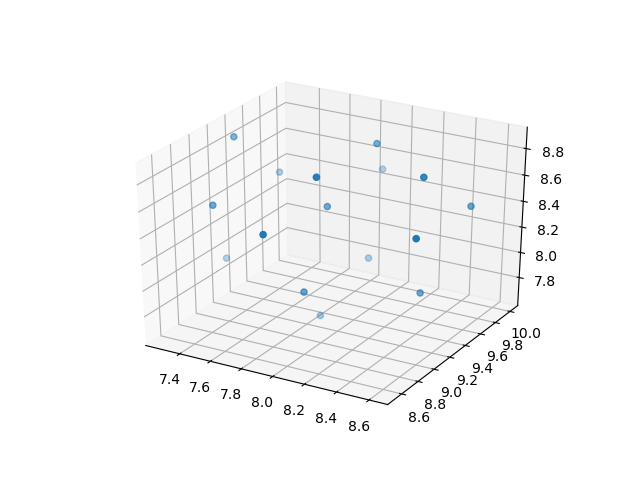

In [22]:
# %matplotlib widget

g = get_graph(cf,10,n_neigh,"cry")
plot3D(g)

In [23]:
graphs_cpu = graphs_cry_cpu + graphs_melt_cpu

In [24]:
print(len(graphs_cry_cpu))
print(len(graphs_melt_cpu))

96192
87264


In [25]:
# shuffle the graphs
np.random.shuffle(graphs_cpu)

## model

In [26]:
class GNN(torch.nn.Module):
    def __init__(self, feature_size):
        super(GNN, self).__init__()
        num_classes = 2
        embedding_size = 1024

        # GNN layers
        self.conv1 = GATConv(feature_size, embedding_size, heads=3, dropout=0.3)
        self.head_transform1 = Linear(embedding_size*3, embedding_size)
        self.pool1 = TopKPooling(embedding_size, ratio=0.8)
        self.conv2 = GATConv(embedding_size, embedding_size, heads=3, dropout=0.3)
        self.head_transform2 = Linear(embedding_size*3, embedding_size)
        self.pool2 = TopKPooling(embedding_size, ratio=0.8)
        self.conv3 = GATConv(embedding_size, embedding_size, heads=3, dropout=0.3)
        self.head_transform3 = Linear(embedding_size*3, embedding_size)
        self.pool3 = TopKPooling(embedding_size, ratio=0.5)

        # Linear layers
        self.linear1 = Linear(embedding_size*2, 1024)
        self.linear2 = Linear(1024, num_classes)

    def forward(self, x, edge_index, batch_index):
        # First block
        x = self.conv1(x, edge_index)
        x = self.head_transform1(x)

        x, edge_index, edge_attr, batch_index, _, _ = self.pool1(x,
                                                        edge_index,
                                                        None,
                                                        batch_index)
        x1 = torch.cat([gmp(x, batch_index), gap(x, batch_index)], dim=1)
        # print(x1)

        # Second block
        x = self.conv2(x, edge_index)
        x = self.head_transform2(x)
        x, edge_index, edge_attr, batch_index, _, _ = self.pool2(x,
                                                        edge_index,
                                                        None,
                                                        batch_index)
        x2 = torch.cat([gmp(x, batch_index), gap(x, batch_index)], dim=1)
        # print(x2)

        # Third block
        x = self.conv3(x, edge_index)
        x = self.head_transform3(x)
        x, edge_index, edge_attr, batch_index, _, _ = self.pool3(x,
                                                        edge_index,
                                                        None,
                                                        batch_index)
        x3 = torch.cat([gmp(x, batch_index), gap(x, batch_index)], dim=1)
        # print(x2)

        # Concat pooled vectors
        x = x1 + x2 + x3

        # Output block
        x = self.linear1(x).relu()
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.linear2(x)
        x = torch.sigmoid(x)
        return x

In [27]:
class GNN_dense(torch.nn.Module):
    def __init__(self, feature_size,n_mols):
        super(GNN_dense, self).__init__()
        num_classes = 2
        embedding_size1 = 32
        embedding_size2 = 16
        linear_size1 = 128
        linear_size2 = 64
        self.feature_size = feature_size
        self.n_mols = n_mols
        self.batch_size = 64

        # GNN layers
        self.conv1 = GATConv(feature_size, embedding_size1, heads=6, dropout=0.1)
        self.head_transform1 = Linear(embedding_size1*6, embedding_size1)

        self.conv2 = GATConv(embedding_size1, embedding_size2, heads=1, dropout=0.1)


        # Linear layers
        self.linear1 = Linear(self.n_mols * embedding_size2, linear_size1)
        self.linear2 = Linear(linear_size1, linear_size2)
        self.linear3 = Linear(linear_size2, num_classes)

    def forward(self, x, edge_index):
        """
        """
        self.batch_size = x.shape[0]//self.n_mols
        
        # in x.shape = (batch*n_mols,n_features)
        # First block
        x = self.conv1(x, edge_index)                  # x.shape = (batch*n_mols,embedding_size1*n_heads1)
        x = self.head_transform1(x)                    # x.shape = (batch*n_mols,embedding_size1)
        
        # Second block
        x = self.conv2(x, edge_index)                  # x.shape = (batch*n_mols,embedding_size2)

        # Reshaping
        x = x.reshape(self.batch_size,self.n_mols,-1)  #  x.shape = (batch,n_mols,embedding_size2)
        x = x.reshape(self.batch_size,-1)              #  x.shape = (batch,n_mols*embedding_size2)
        
        #output block
        x = self.linear1(x)                            # x.shape = (batch,linear_size1)
        x = F.leaky_relu(x)

        x = F.dropout(x, p=0.2, training=self.training)
        
        x = self.linear2(x)                            # x.shape = (batch,linear_size2)
        x = F.leaky_relu(x)

        x = self.linear3(x)                            # x.shape = (batch,num_classes)
        x = F.sigmoid(x)
        return x

In [28]:
import os
in_channels = graphs_cpu[0].num_features
out_channels = 2
lr = 1e-4
n_epochs = 400
batch_size=64
test_train_split = 0.8
model_name = "LOCAL_Classifier.pt"
model_loaded = False
force_train = True
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if os.path.exists("./"+model_name) and not force_train:
    model = torch.load("./"+model_name)
    model_loaded = True
else:
    model = GNN_dense(in_channels,n_neigh+1)

model = model.to(device)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, step_size=300, gamma=0.5)


In [29]:
graphs_device = []
for graph in tqdm(graphs_cpu):
    graphs_device.append(graph.to(device))

100%|██████████| 183456/183456 [00:14<00:00, 12685.34it/s]


In [30]:
graphs = graphs_device
total_graphs = len(graphs)

In [31]:
print("Using:",device )
print("total_graphs:", total_graphs)
print("batch Size:" , batch_size)
print("number of batches:",total_graphs//batch_size)
print("Neighbours:",n_neigh)
print("Model\n",model)

Using: cuda
total_graphs: 183456
batch Size: 64
number of batches: 2866
Neighbours: 15
Model
 GNN_dense(
  (conv1): GATConv(6, 32, heads=6)
  (head_transform1): Linear(in_features=192, out_features=32, bias=True)
  (conv2): GATConv(32, 16, heads=1)
  (linear1): Linear(in_features=256, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=2, bias=True)
)


In [32]:
split = int(test_train_split * total_graphs)

train_loader = DataLoader(graphs[:split], batch_size=batch_size, shuffle=True)
test_loader = DataLoader(graphs[split:], batch_size=batch_size, shuffle=True)

In [33]:
cross_entropy_loss = torch.nn.CrossEntropyLoss()
MSE_loss = torch.nn.MSELoss()

def train():
    model.train()
    model.zero_grad()
    model.float()
    all_loss_cross = 0
    all_loss_mse = 0
    for data in train_loader:
        optimizer.zero_grad()
        data = data
        pred = model(data.x.float(),data.edge_index)

        labels = F.one_hot(data.y,num_classes = 2).float().to(device)
#         labels = data.y.to(device).float()
    
        loss_cross = torch.sqrt(cross_entropy_loss(pred.float(), labels))
#         loss_cross = 0
        loss_mse = MSE_loss(pred.float(),labels)

#         loss_cross.backward()
        loss_mse.backward()
        all_loss_cross += float(loss_cross)
        all_loss_mse += float(loss_mse)
        optimizer.step()


    return all_loss_cross / len(train_loader), all_loss_mse/len(train_loader)

In [34]:
def test():
    model.eval()
    model.zero_grad()
    model.float()
    all_loss_cross = 0
    all_loss_mse = 0
    for data in test_loader:
        optimizer.zero_grad()
        pred = model(data.x.float(),data.edge_index)
        labels = F.one_hot(data.y,num_classes = 2).float().to(device)
#         labels = data.y.to(device).float()

        loss_cross = torch.sqrt(cross_entropy_loss(pred.float(), labels))
        loss_mse = MSE_loss(pred.float(),labels)
#         loss_cross = 0

        all_loss_cross += float(loss_cross)
        all_loss_mse += float(loss_mse)


    return all_loss_cross / len(test_loader), all_loss_mse/len(test_loader)

In [35]:
train_losses = []
test_losses = []

if model_loaded:
    print("Pretrained Model Loaded, no training required")
else:
    for epoch in range(1, n_epochs + 1):

        train_loss_cross,train_loss_mse = train()
        test_loss_cross,test_loss_mse = test()

        print(f"Epoch: {epoch:03d}")
        print(f'\tTrain:\tEntropy Loss: {train_loss_cross:.4f} \tMSE Loss: {train_loss_mse:.4f}')
        print(f'\tTest: \tEntropy  Loss: {test_loss_cross:.4f} \tMSE Loss: {test_loss_mse:.4f}')

        train_losses.append([train_loss_cross,train_loss_mse]);
        test_losses.append([test_loss_cross,test_loss_mse]);

        scheduler.step()
    torch.save(model,"./"+model_name)

/home2/naval.s/anaconda3/envs/GAENN/lib/python3.7/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 001
	Train:	Entropy Loss: 0.6669 	MSE Loss: 0.0865
	Test: 	Entropy  Loss: 0.5671 	MSE Loss: 0.0028
Epoch: 002
	Train:	Entropy Loss: 0.5655 	MSE Loss: 0.0034
	Test: 	Entropy  Loss: 0.5617 	MSE Loss: 0.0008
Epoch: 003
	Train:	Entropy Loss: 0.5627 	MSE Loss: 0.0019
	Test: 	Entropy  Loss: 0.5620 	MSE Loss: 0.0012
Epoch: 004
	Train:	Entropy Loss: 0.5614 	MSE Loss: 0.0011
	Test: 	Entropy  Loss: 0.5599 	MSE Loss: 0.0000
Epoch: 005
	Train:	Entropy Loss: 0.5610 	MSE Loss: 0.0008
	Test: 	Entropy  Loss: 0.5598 	MSE Loss: 0.0000
Epoch: 006
	Train:	Entropy Loss: 0.5613 	MSE Loss: 0.0013
	Test: 	Entropy  Loss: 0.5598 	MSE Loss: 0.0000
Epoch: 007
	Train:	Entropy Loss: 0.5610 	MSE Loss: 0.0011
	Test: 	Entropy  Loss: 0.5605 	MSE Loss: 0.0003
Epoch: 008
	Train:	Entropy Loss: 0.5604 	MSE Loss: 0.0005
	Test: 	Entropy  Loss: 0.5597 	MSE Loss: 0.0000
Epoch: 009
	Train:	Entropy Loss: 0.5607 	MSE Loss: 0.0009
	Test: 	Entropy  Loss: 0.5597 	MSE Loss: 0.0000
Epoch: 010
	Train:	Entropy Loss: 0.5606 	MSE L

KeyboardInterrupt: 

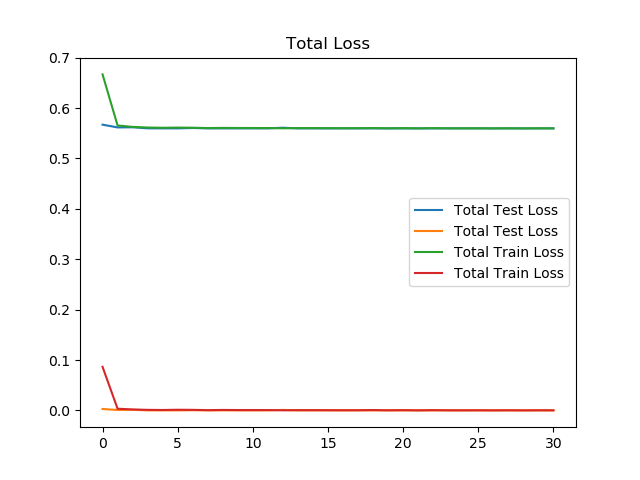

In [47]:
if not model_loaded:
    plt.figure()
    plt.plot(test_losses, label='Total Test Loss')
    plt.plot(train_losses, label='Total Train Loss')
    plt.legend()
    plt.title('Total Loss')
    plt.show()

In [39]:
test_loader_melt = DataLoader(graphs_melt_cpu[::100], batch_size=1)
pred_melt=[]
for data in tqdm(test_loader_melt):
    model.eval()
    data = data.to(device)
    pred = model(data.x.float(),data.edge_index)
    pred_melt.append(pred.cpu().detach().numpy())
pred_melt = np.array(pred_melt)


100%|██████████| 873/873 [00:02<00:00, 346.09it/s]


In [41]:
test_loader_cry = DataLoader(graphs_cry_cpu[::100], batch_size=1)
pred_cry=[]
for data in tqdm(test_loader_cry):
    model.eval()
    data = data.to(device)
    pred = model(data.x.float(),data.edge_index)
    pred_cry.append(pred.cpu().detach().numpy())

pred_cry = np.array(pred_cry)


100%|██████████| 962/962 [00:02<00:00, 346.85it/s]


In [45]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_test = test_loader_melt
cm = confusion_matrix(y_test, predictions)
ConfusionMatrixDisplay(cm).plot()


(array([[[1.0000000e+00, 2.5291089e-13]],
 
        [[1.0000000e+00, 1.4601428e-19]],
 
        [[1.0000000e+00, 3.2019649e-08]],
 
        ...,
 
        [[1.0000000e+00, 9.4337721e-13]],
 
        [[1.0000000e+00, 6.4583278e-10]],
 
        [[9.9999988e-01, 7.9394034e-08]]], dtype=float32),
 array([[[5.54802523e-11, 1.00000000e+00]],
 
        [[1.82865476e-11, 1.00000000e+00]],
 
        [[1.70041687e-07, 9.99999881e-01]],
 
        ...,
 
        [[9.51028427e-13, 1.00000000e+00]],
 
        [[4.15164620e-13, 1.00000000e+00]],
 
        [[1.03429706e-07, 9.99999881e-01]]], dtype=float32))

IndexError: index 1 is out of bounds for axis 1 with size 1

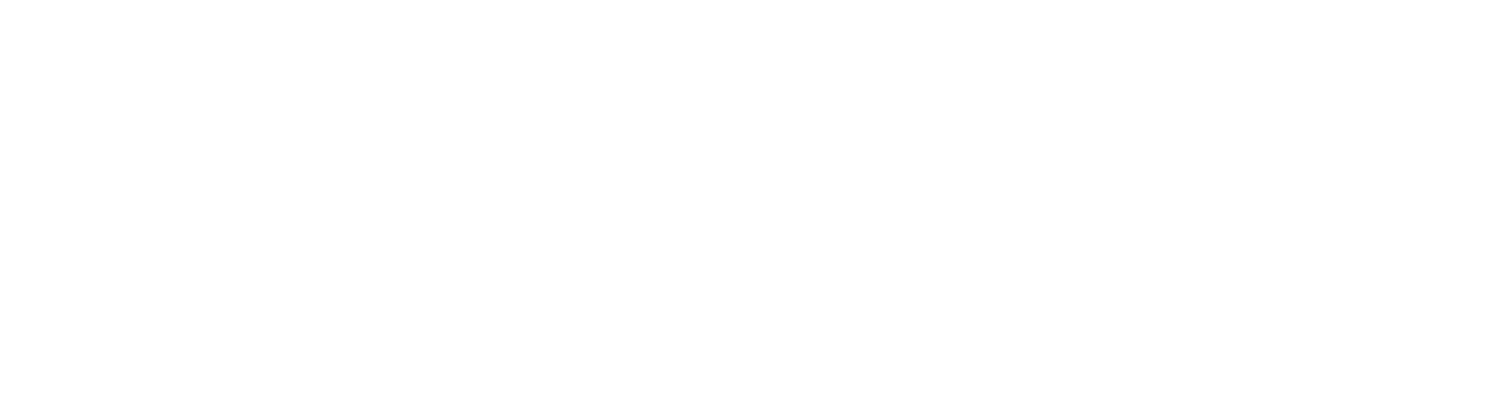

In [44]:
# %matplotlib widget

fig = plt.figure(figsize=(15,4))
data_melt = pred_melt
data_cry = pred_cry

plt.scatter(data_melt[:,0],data_melt[:,1],c="r",label="melt")
plt.scatter(data_cry[:,0],data_cry[:,1],c="b",label="crystal")
plt.legend()
plt.show()

In [ ]:
n_sample = 1000
n_class = 2
n_1 = 1000
n_2 = 1000